In [49]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
import numpy as np

In [2]:
RESULTS_FOLDER = 'results'
parameters = {
    "cell_cycle":"Duration of the cell cycle $t_{total}$",
    "average_healthy_glucose_absorption":"Average healthy glucose absorption $\mu_{g,healthy}$",
    "average_cancer_glucose_absorption":"Average cancer glucose absorption $\mu_{g,cancer}$",
    "average_healthy_oxygen_consumption":"Average healthy oxygen consumption $\mu_{o,healthy}$",
    "average_cancer_oxygen_consumption":"Average cancer oxygen consumption $\mu_{o,cancer}$"
             }
EVALUATION_FILE = "evaluation_stats.csv"

# Plot results

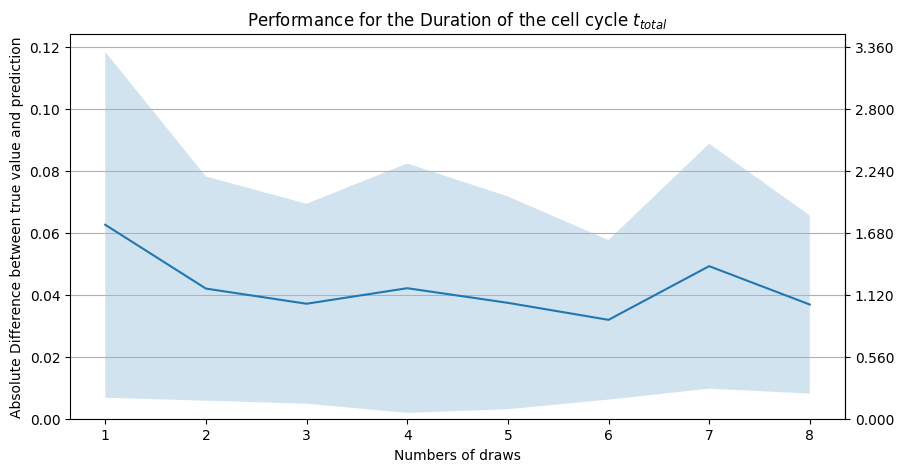

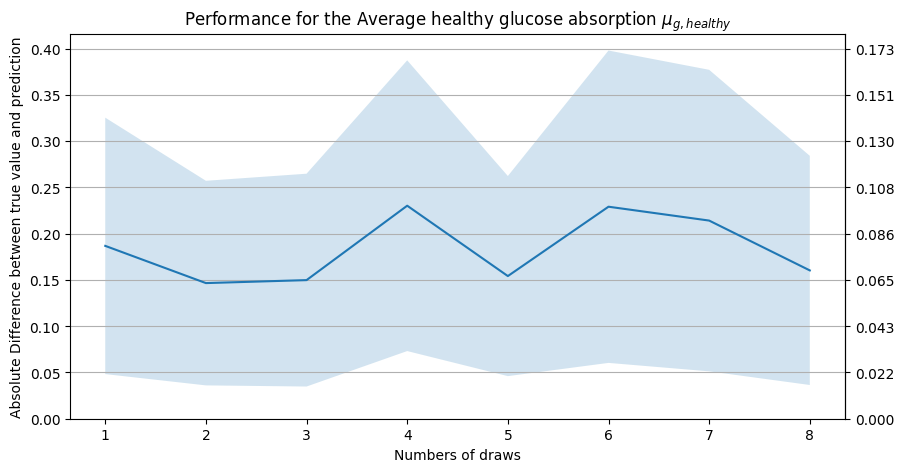

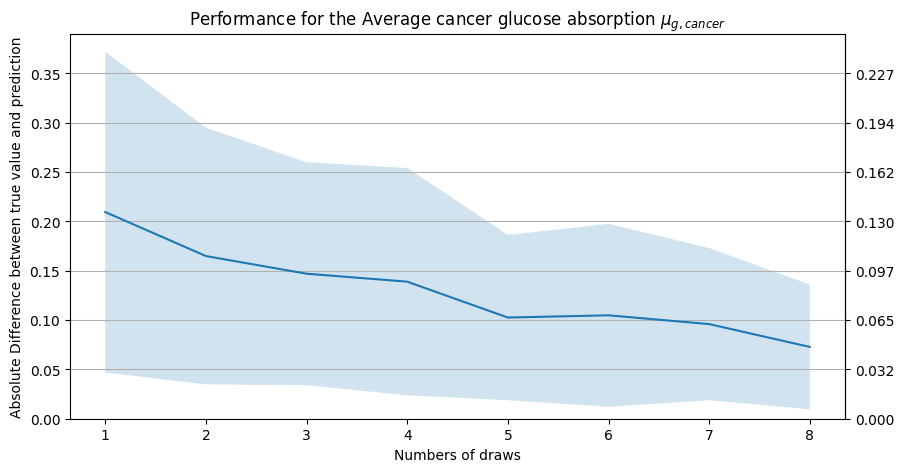

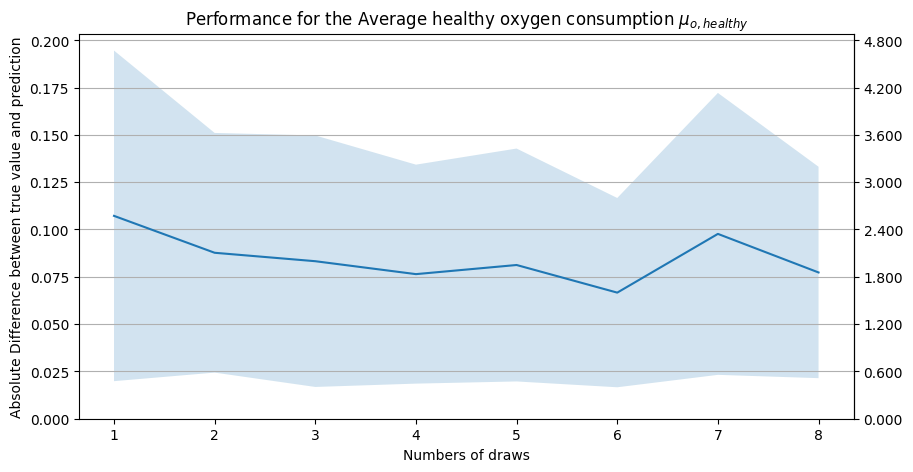

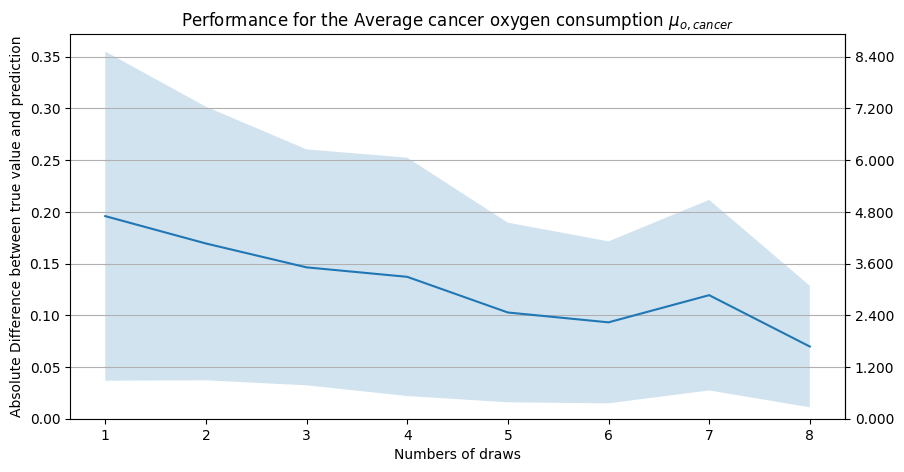

In [47]:
# Find best indices
best_indices = dict()
for draw in range(1,9):
    df = pd.read_csv(os.path.join(RESULTS_FOLDER, f"hyp_search_no_dose_for_{draw}_draws", "performances.csv"))
    best_indices[draw] = df["Performance"].idxmin()

param_ranges = pd.read_csv(os.path.join("simulation","parameter_data.csv"), index_col=0)
for key, value in parameters.items():
    means = dict()
    stds = dict()
    for draw in range(1,9):
        df = pd.read_csv(os.path.join(RESULTS_FOLDER, f"hyp_search_no_dose_for_{draw}_draws", str(best_indices[draw]), "evaluation_stats.csv"))
        means[draw] = df.loc[df["Parameters"] == key, "Means"].iloc[0]
        stds[draw] = df.loc[df["Parameters"] == key, "Standard Deviation"].iloc[0]
    
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(111)
    X = means.keys()
    Y_mean = np.array(list(means.values()))
    Y_stds = np.array(list(stds.values()))
    ax.plot(X, Y_mean)
    ax.fill_between(X, Y_mean-Y_stds, Y_mean+Y_stds, alpha=0.2)
    plt.title(f"Performance for the {value}")
    ax.set_ylabel("Absolute Difference between true value and prediction")
    ax.set_xlabel("Numbers of draws")
    ax.grid(axis='y')
    ax.set_ylim(0, None)
    ax2 = ax.secondary_yaxis("right")
    min = param_ranges.loc[key]["Minimum"]
    max = param_ranges.loc[key]["Maximum"]
    
    ticks = np.array(ax.get_yticks())*(max-min)
    ax2.set_yticks(ax.get_yticks(), [f"{tick:.3f}" for tick in ticks])
    plt.savefig(os.path.join("pictures", f"Performance for {key}.pdf"))
    

# Hyperparameter tuning

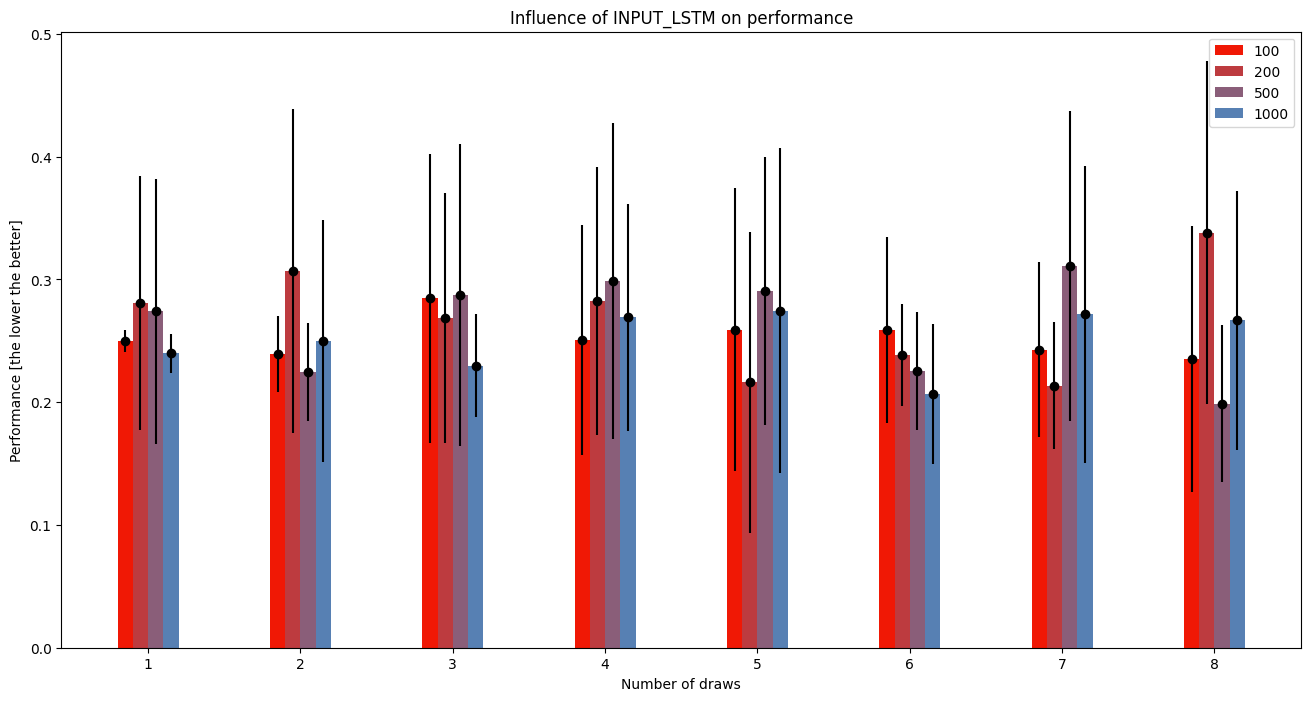

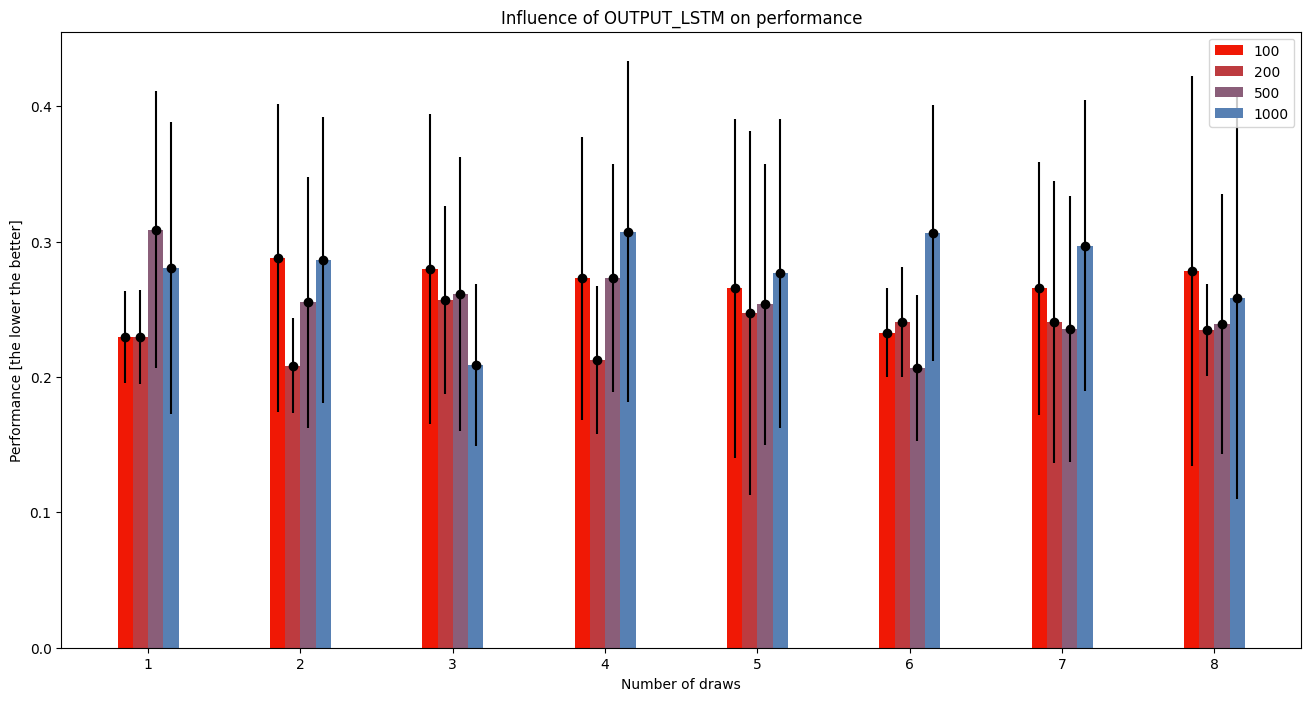

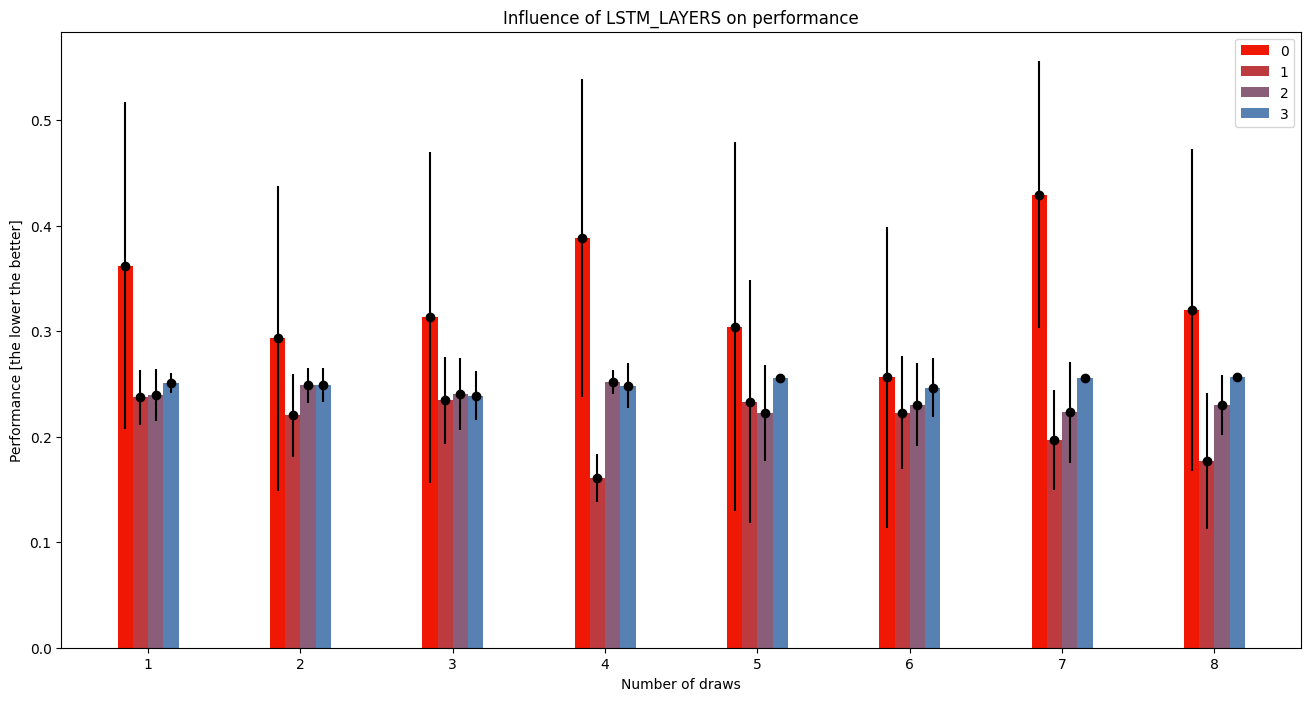

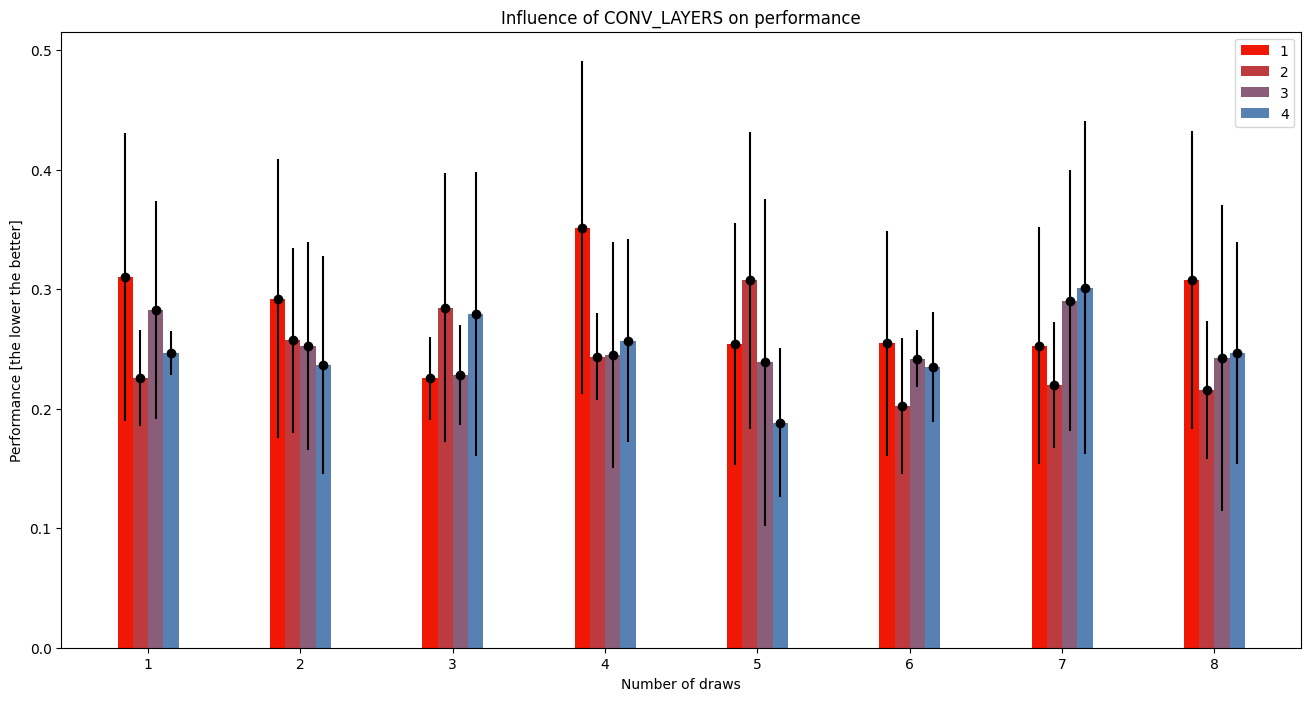

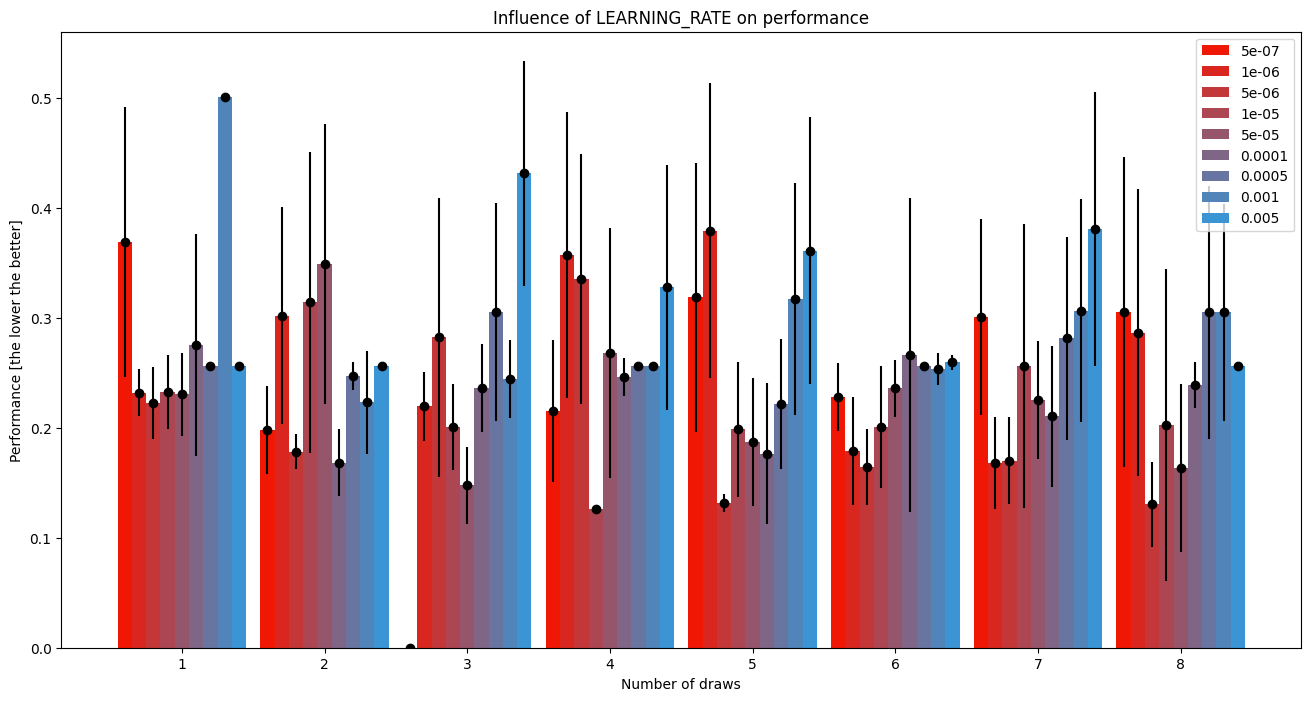

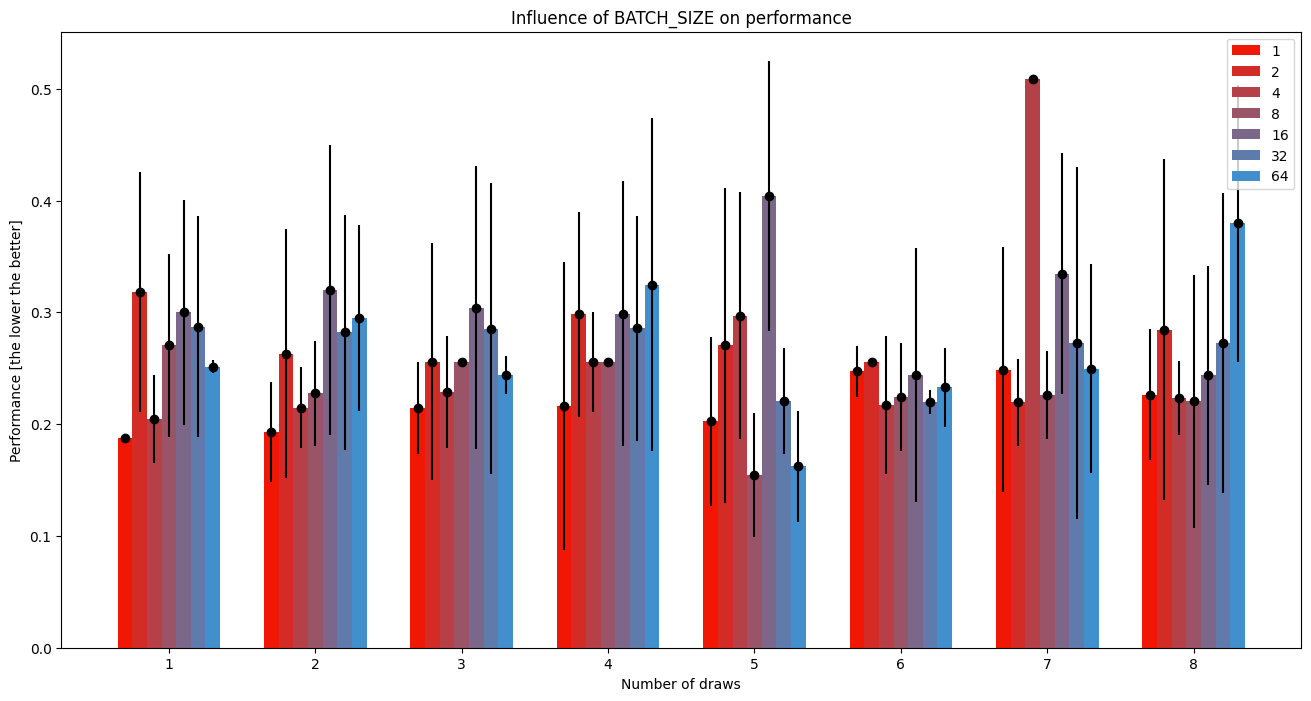

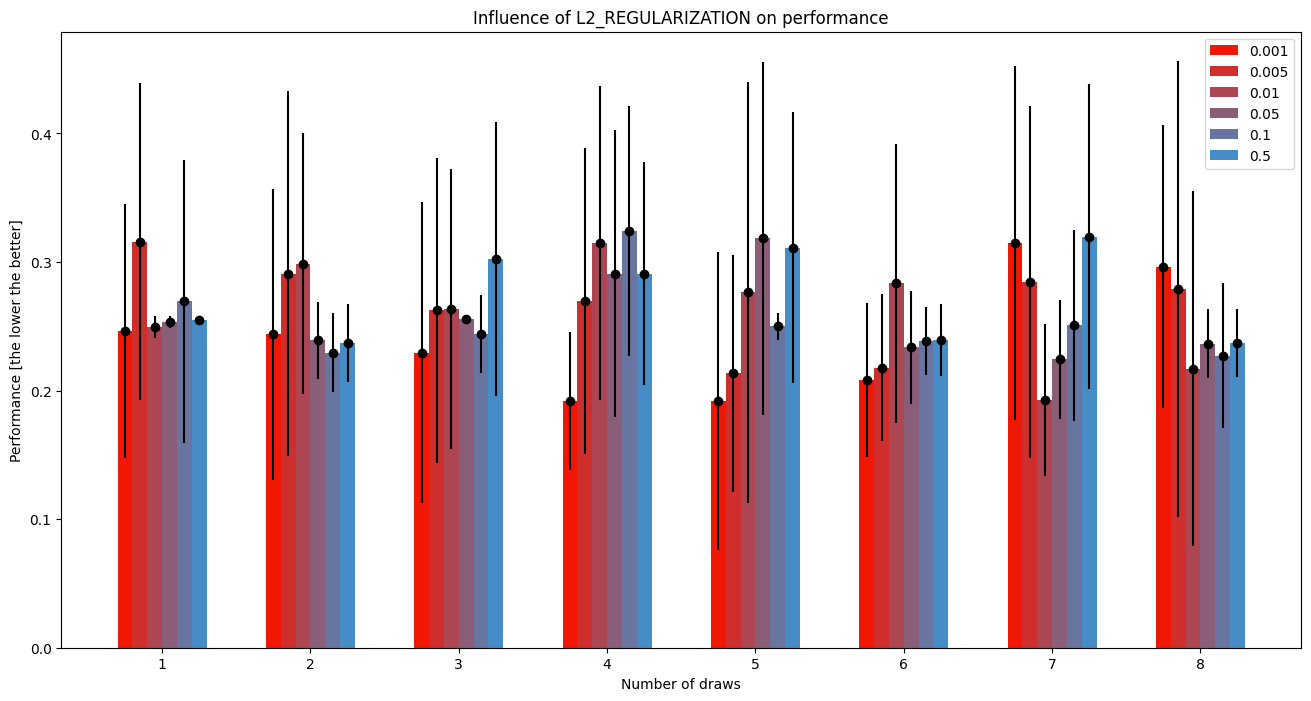

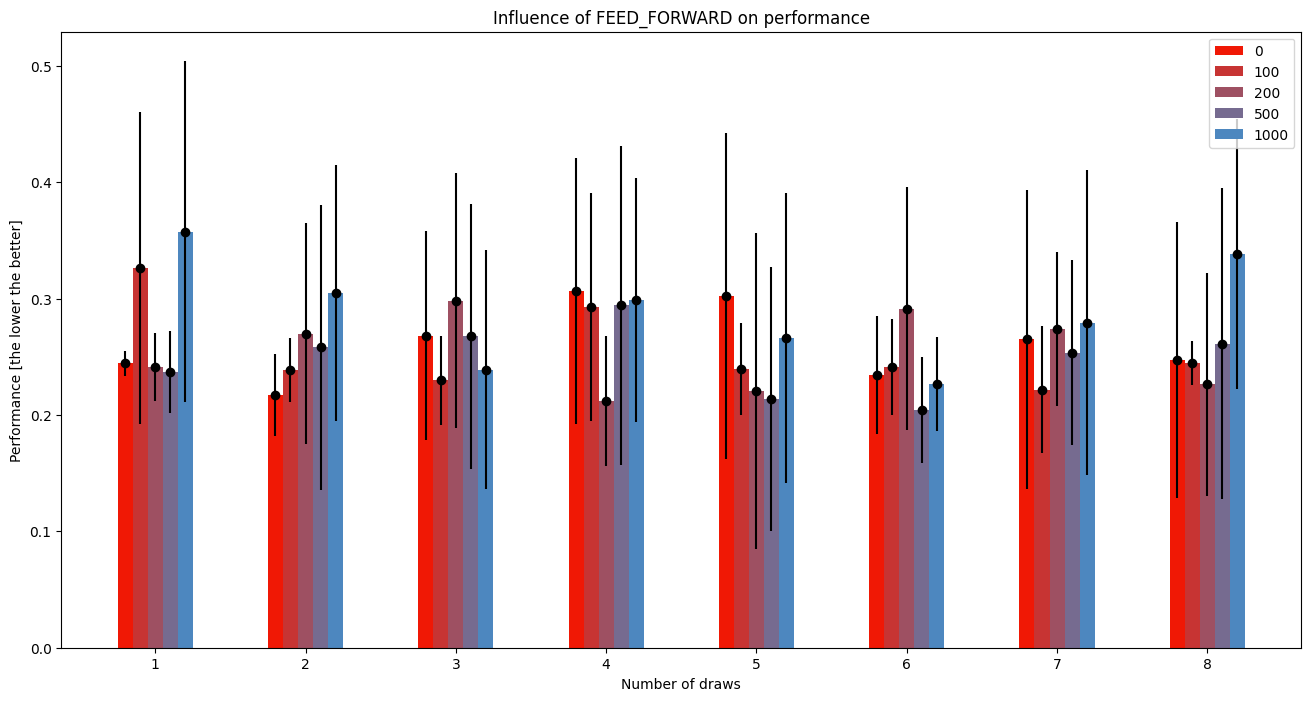

In [50]:
parameters_to_study = ["INPUT_LSTM","OUTPUT_LSTM","LSTM_LAYERS","CONV_LAYERS","LEARNING_RATE","BATCH_SIZE","L2_REGULARIZATION", "FEED_FORWARD"]
dataframes = [pd.read_csv(os.path.join("results",f"hyp_search_no_dose_for_{draw}_draws", "performances.csv"), index_col=0) for draw in range(1,9)]

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

for parameter_to_study in parameters_to_study:
    possible_param_value = pd.concat(dataframes, ignore_index=True)[parameter_to_study].unique()
    barWidth = 0.1
    datas = {}
    for draw in range(1,9):
        datas[draw] = {param_value: list(dataframes[draw-1].loc[dataframes[draw-1][parameter_to_study]==param_value, 'Performance']) for param_value in possible_param_value}
    
    fig = plt.subplots(figsize =(16, 8)) 

    colors = [colorFader('#f01805','#24a3ed',j/len(possible_param_value)) for j in range(len(possible_param_value))]
    
    for i, param_value in enumerate(sorted(possible_param_value)):
        X = [x + i*barWidth for x in range(8)]
        Y_mean = [np.mean(datas[draw][param_value]) if len(datas[draw][param_value])!=0 else 0  for draw in range(1,9)]
        Y_std = [np.std(datas[draw][param_value]) if len(datas[draw][param_value])!=0 else 0 for draw in range(1,9)]
        plt.bar(X, Y_mean, label=param_value, width=barWidth, color=colors[i])
        plt.errorbar(X, Y_mean, yerr=Y_std, fmt='o', color='black')
    
    a = len(possible_param_value)
    plt.xticks([r + (a/2-0.5)*barWidth for r in range(8)], [str(i) for i in range(1,9)])
    plt.ylabel("Performance [the lower the better]")
    plt.xlabel("Number of draws")
    plt.title(f"Influence of {parameter_to_study} on performance")
    plt.legend()
    plt.savefig(os.path.join("pictures", f"{parameter_to_study}_influence.pdf"))